In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import allel
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [3]:
chr7_females = allel.read_vcf('../steps/recode_vcf/chr7_females.recode.vcf')

In [4]:
chrX_females = allel.read_vcf('../steps/recode_vcf/chrX_females.recode.vcf')

In [5]:
chr7_males = allel.read_vcf('../steps/recode_vcf/chr7_males.recode.vcf')

In [6]:
chrX_males = allel.read_vcf('../../../../data/haploidified_chrX_males/hap_chrX_males.vcf.gz')

In [7]:
meta_data_samples = pd.read_table("../data/metadata.txt", sep=" ")

In [8]:
meta_data_females = meta_data_samples[meta_data_samples['Sex'] == 'F']
meta_data_males = meta_data_samples[(meta_data_samples['Sex'] == 'M') & (meta_data_samples['Genus'] == 'Papio')]

In [9]:
def vcf2df(vcf):
    gt = allel.GenotypeArray(vcf['calldata/GT'])
    ac = gt.count_alleles()
    
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    gf = gt.compress(flt, axis=0)
    
    gn = gf.to_n_alt()
    
    return gn

In [10]:
def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

# t-SNE

In [12]:
def tsne(df, vcf, meta_data):
    tsne_pipeline = make_pipeline(StandardScaler(), TSNE(n_components=2))
    
    X_embedded = tsne_pipeline.fit_transform(df.T)
    tsne_df = pd.DataFrame(data = X_embedded, index=vcf['samples'])
    
    pop_df = meta_data.set_index('PGDP_ID')
    
    tsne_df.index = tsne_df.index.str.replace('Sci_', '', regex=True)
    
    final_tsne = pd.merge(tsne_df, pop_df['C_origin'], left_index=True, right_index=True)
    
    return final_tsne

In [27]:
def plot_tsne(tsne_df, pop, chrom):
    fig, ax = plt.subplots(figsize = (6,5))
    
    groups = tsne_df.groupby('C_origin')
    for name, group in groups:
        ax.scatter(group[0], group[1], label=name)
    
    ax.set_xlabel('Component 1', fontsize = 10)
    ax.set_ylabel('Component 2', fontsize = 10)
    ax.text(s = 'Chromosome {}'.format(chrom), size=20, rotation=0, ha = 'center', x=0.5,y=1.06,transform=ax.transAxes)
#     plt.title('{}'.format(pop), fontsize = 20, rotation='vertical',x=-0.22,y=0.35)
    ax.legend(bbox_to_anchor=(1.01, 0.75))
#     ax.get_legend().remove()
    
    
    fig.savefig('../figures/tsne_{}_{}.pdf'.format(pop, chrom), bbox_inches='tight')

### Females

In [14]:
females_chr7_df = vcf2df(chr7_females)
pruned_females_7 = ld_prune(females_chr7_df, size=200, step=20, threshold=.1, n_iter=1)

iteration 1 retaining 107987 removing 851689 variants


In [15]:
females_chr7 = tsne(pruned_females_7, chr7_females, meta_data_females)

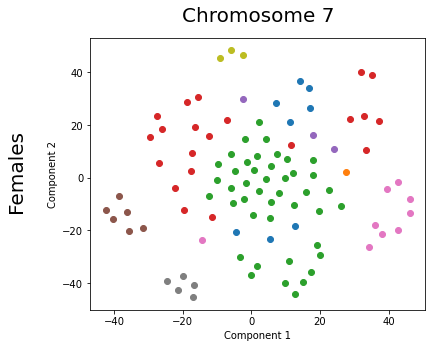

In [16]:
plot_tsne(females_chr7, 'Females', '7')

In [28]:
females_chrX_df = vcf2df(chrX_females)
pruned_females_X = ld_prune(females_chrX_df, size=200, step=20, threshold=.1, n_iter=1)

iteration 1 retaining 164066 removing 1423559 variants


In [29]:
females_chrX = tsne(pruned_females_X, chrX_females, meta_data_females)

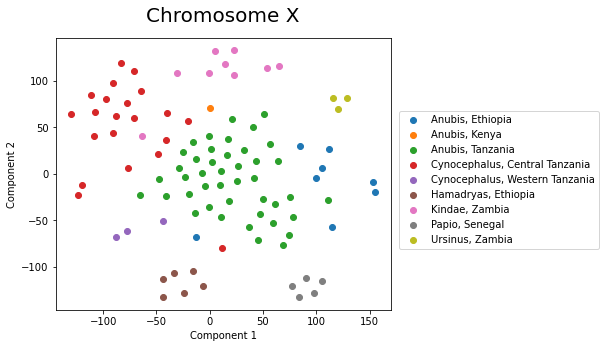

In [30]:
plot_tsne(females_chrX, 'Females', 'X')

### Males

In [17]:
males_chr7_df = vcf2df(chr7_males)
pruned_males_7 = ld_prune(males_chr7_df, size=200, step=20, threshold=.1, n_iter=1)

iteration 1 retaining 443737 removing 2890829 variants


In [18]:
males_chr7 = tsne(pruned_males_7, chr7_males, meta_data_males)

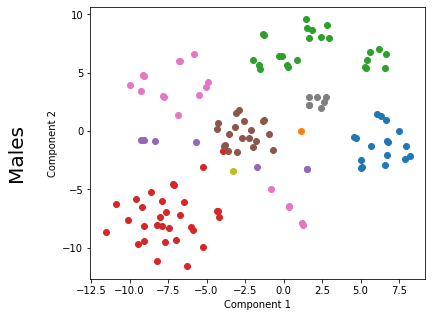

In [21]:
plot_tsne(males_chr7, 'Males', '7')

In [24]:
males_chrX_df = vcf2df(chrX_males)
pruned_males_X = ld_prune(males_chrX_df, size=200, step=20, threshold=.1, n_iter=1)

iteration 1 retaining 146419 removing 1245718 variants


In [25]:
males_chrX = tsne(pruned_males_X, chrX_males, meta_data_males)

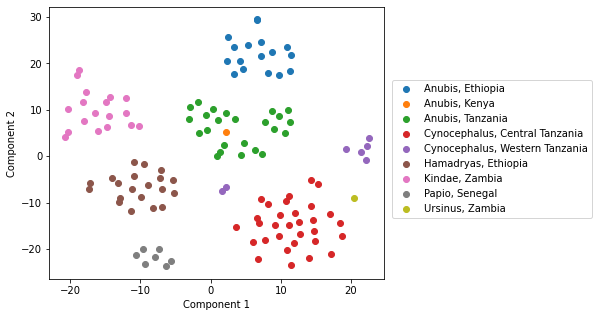

In [26]:
plot_tsne(males_chrX, 'Males', 'X')